[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaloADBA/ELE8812-demos/blob/main/Demos/Lesson%204/Leçon_4_Demo_hom.ipynb)

# ELE8812 - Traitement fréquentielle

## Démo : Rehaussement par filtrage homomorphique

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import cv2

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Option d'affichage
plt.rcParams['figure.figsize'] = (16,10)
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.titlepad'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
!git clone https://github.com/MaloADBA/ELE8812-demos.git Repo

Mounted at /content/drive


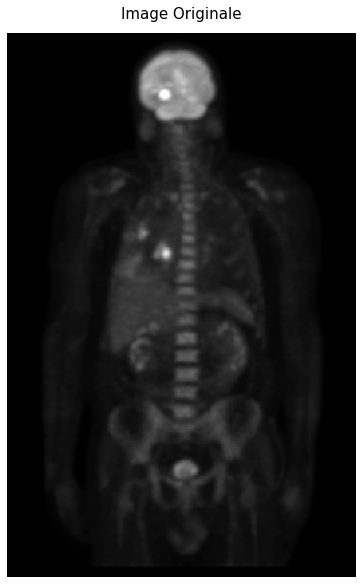

In [3]:
# Charger image
A = np.double(plt.imread('Repo/Data/PET.tif'));

out = np.zeros(A.shape, np.double)
plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title('Image Originale'); plt.axis('off'); plt.show();

In [4]:
def filtpb_gauss(A, fc, pad):
    """ Application d'un filtre gaussien sur une image im à une fréquence de coupure fc dans 
        le domaine fréquentiel
    
    A (ndarray): Image d'entrée
    fc (float): Fréquence de coupure
    pad (int): Nombre de pixels de padding
    """
    M,N = A.shape
    M+=pad
    N+=pad

    # Image dans le domaine fréquentiel
    AA = np.fft.fftshift(np.fft.fft2(A, (M,N)))

    M0 = np.ceil((M+1) / 2)
    N0 = np.ceil((N+1) / 2)

    U, V = np.mgrid[1:M+1, 1:N+1]
    D2 = (U - M0)**2 + (V - N0)**2
    
    # Réponse fréquentielle du filtre gaussien
    HH = np.exp(-D2 / (2 * fc**2))
    
    # Application du filtre et retour au domaine spatial
    BB = np.fft.ifftshift(AA * HH)
    B = np.fft.ifft2(BB)
    B = np.real(B)
    return B[:A.shape[0],:A.shape[1]]       

## Paramètres de filtrage

In [5]:
gh = 2
gl = 0.5
fc = 80

## Filtrage homomorphique

In [6]:
B = np.log(A+1);

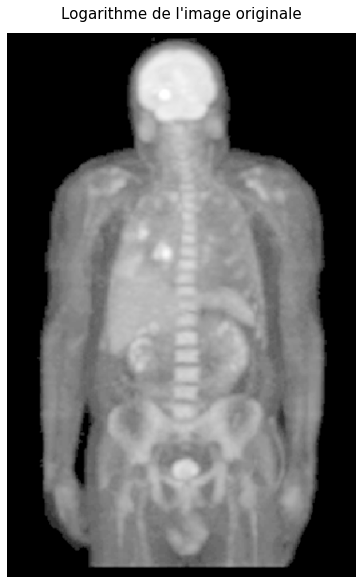

In [7]:
out = np.zeros(B.shape, np.double)
plt.imshow(cv2.normalize(B, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); 
plt.title("Logarithme de l'image originale"); 
plt.axis('off'); 
plt.show();

In [8]:
C = gh * B - (gh-gl) * filtpb_gauss(B, fc,pad=0);

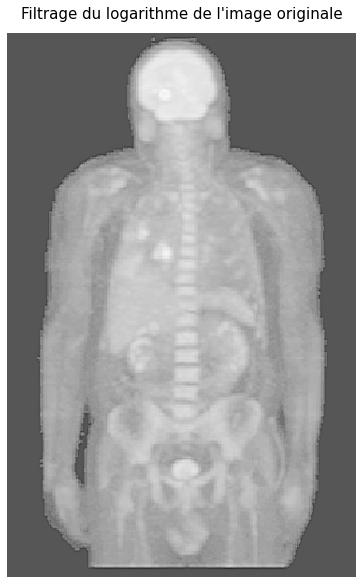

In [9]:
out = np.zeros(C.shape, np.double)
plt.imshow(cv2.normalize(C, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); 
plt.title("Filtrage du logarithme de l'image originale"); 
plt.axis('off'); 
plt.show();

In [10]:
D = np.exp(C)

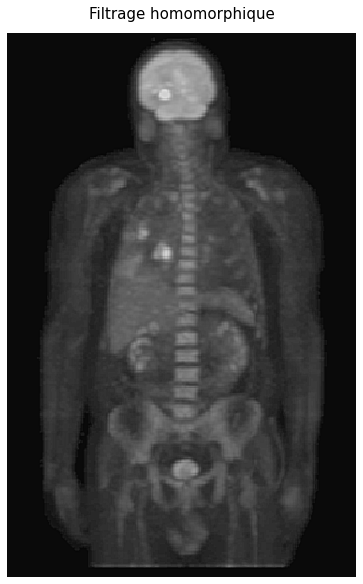

In [11]:
out = np.zeros(B.shape, np.double)
plt.imshow(cv2.normalize(D, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); 
plt.title("Filtrage homomorphique"); 
plt.axis('off'); 
plt.show();

## Comparaison

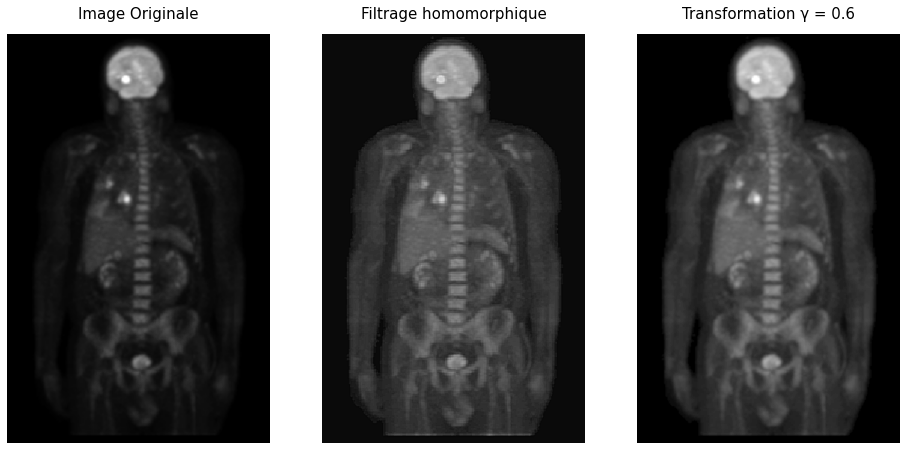

In [12]:
out = np.zeros(A.shape, np.double)
plt.subplot(131); plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title('Image Originale'); plt.axis('off');
out = np.zeros(B.shape, np.double)
plt.subplot(132); plt.imshow(cv2.normalize(D, out, 1.0, 0.0, cv2.NORM_MINMAX), cmap='gray'); plt.title("Filtrage homomorphique"); plt.axis('off');
out = np.zeros(A.shape, np.double)
plt.subplot(133); plt.imshow(cv2.normalize(A, out, 1.0, 0.0, cv2.NORM_MINMAX)**0.6, cmap='gray'); plt.title('Transformation \u03B3 = 0.6'); plt.axis('off'); plt.show();